<a href="https://colab.research.google.com/github/banno-0720/learning_PyTorch/blob/main/Amazon_Stock_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import opendatasets as od

In [5]:
od.download("https://www.kaggle.com/datasets/varpit94/amazon-stock-data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: himanshugoyal2004
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/varpit94/amazon-stock-data


100%|██████████| 119k/119k [00:00<00:00, 24.5MB/s]

In [7]:
data = pd.read_csv("/content/amazon-stock-data/AMZN.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
6252,2022-03-18,3136.260010,3231.879883,3120.219971,3225.010010,3225.010010,5141300
6253,2022-03-21,3222.419922,3261.679932,3191.060059,3229.830078,3229.830078,3326900
6254,2022-03-22,3236.110107,3323.340088,3233.979980,3297.780029,3297.780029,3204300
6255,2022-03-23,3274.100098,3327.399902,3253.739990,3268.159912,3268.159912,2790600


In [8]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,1.958333
1,1997-05-16,1.729167
2,1997-05-19,1.708333
3,1997-05-20,1.635417
4,1997-05-21,1.427083
...,...,...
6252,2022-03-18,3225.010010
6253,2022-03-21,3229.830078
6254,2022-03-22,3297.780029
6255,2022-03-23,3268.159912


In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-10-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


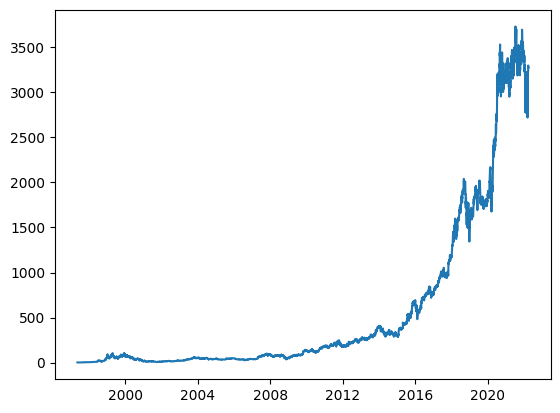

In [10]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [11]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,1.583333,1.500000,1.395833,1.427083,1.635417,1.708333,1.729167,1.958333
1997-05-28,1.531250,1.583333,1.500000,1.395833,1.427083,1.635417,1.708333,1.729167
1997-05-29,1.505208,1.531250,1.583333,1.500000,1.395833,1.427083,1.635417,1.708333
1997-05-30,1.500000,1.505208,1.531250,1.583333,1.500000,1.395833,1.427083,1.635417
1997-06-02,1.510417,1.500000,1.505208,1.531250,1.583333,1.500000,1.395833,1.427083
...,...,...,...,...,...,...,...,...
2022-03-18,3225.010010,3144.780029,3062.080078,2947.330078,2837.060059,2910.489990,2936.350098,2785.580078
2022-03-21,3229.830078,3225.010010,3144.780029,3062.080078,2947.330078,2837.060059,2910.489990,2936.350098
2022-03-22,3297.780029,3229.830078,3225.010010,3144.780029,3062.080078,2947.330078,2837.060059,2910.489990


In [12]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[1.58333300e+00, 1.50000000e+00, 1.39583300e+00, ...,
        1.70833300e+00, 1.72916700e+00, 1.95833300e+00],
       [1.53125000e+00, 1.58333300e+00, 1.50000000e+00, ...,
        1.63541700e+00, 1.70833300e+00, 1.72916700e+00],
       [1.50520800e+00, 1.53125000e+00, 1.58333300e+00, ...,
        1.42708300e+00, 1.63541700e+00, 1.70833300e+00],
       ...,
       [3.29778003e+03, 3.22983008e+03, 3.22501001e+03, ...,
        2.94733008e+03, 2.83706006e+03, 2.91048999e+03],
       [3.26815991e+03, 3.29778003e+03, 3.22983008e+03, ...,
        3.06208008e+03, 2.94733008e+03, 2.83706006e+03],
       [3.27298999e+03, 3.26815991e+03, 3.29778003e+03, ...,
        3.14478003e+03, 3.06208008e+03, 2.94733008e+03]])

In [13]:
shifted_df_as_np.shape

(6250, 8)

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995532, -1.        , ..., -0.99983244,
        -0.99982127, -0.99969839],
       [-0.99993856, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982127],
       [-0.99995252, -0.99993856, -0.99989946, ..., -0.99998324,
        -0.99987154, -0.99983244],
       ...,
       [ 0.76749026,  0.7310559 ,  0.72847293, ...,  0.57958345,
         0.52045765,  0.55983012],
       [ 0.75160813,  0.76749026,  0.7310574 , ...,  0.64111136,
         0.57958345,  0.52045765],
       [ 0.75419799,  0.75160813,  0.76749156, ...,  0.68545433,
         0.64111136,  0.57958345]])

In [15]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6250, 7), (6250,))

In [16]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982127, -0.99983244, ..., -0.99998324,
        -1.        , -0.99995532],
       [-0.99982127, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998324, ..., -0.99994415,
        -0.99989946, -0.99993856],
       ...,
       [ 0.55983012,  0.52045765,  0.57958345, ...,  0.68545433,
         0.72847293,  0.7310559 ],
       [ 0.52045765,  0.57958345,  0.64111136, ...,  0.72847293,
         0.7310574 ,  0.76749026],
       [ 0.57958345,  0.64111136,  0.68545433, ...,  0.7310574 ,
         0.76749156,  0.75160813]])

In [17]:
split_index = int(len(X) * 0.95)

split_index

5937

In [18]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5937, 7), (313, 7), (5937,), (313,))

In [19]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5937, 7, 1), (313, 7, 1), (5937, 1), (313, 1))

In [20]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5937, 7, 1]),
 torch.Size([313, 7, 1]),
 torch.Size([5937, 1]),
 torch.Size([313, 1]))

In [21]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [22]:
train_dataset

In [23]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [27]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [28]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.098
Batch 200, Loss: 0.051
Batch 300, Loss: 0.016

Val Loss: 0.431
***************************************************

Epoch: 2
Batch 100, Loss: 0.006
Batch 200, Loss: 0.006
Batch 300, Loss: 0.005

Val Loss: 0.138
***************************************************

Epoch: 3
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.052
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.019
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.011
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.005
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.003
*****************

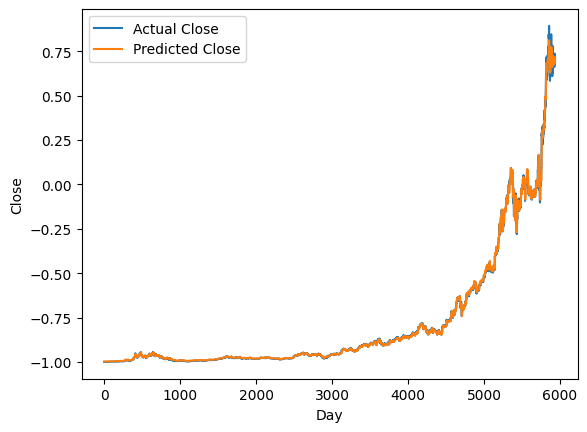

In [29]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [30]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([   6.1535218 ,    6.1816459 ,    6.20765791, ..., 3204.26640478,
       3205.3187798 , 3199.5697908 ])

In [31]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([1.58329953e+00, 1.53127550e+00, 1.50526348e+00, ...,
       3.20652000e+03, 3.18527007e+03, 3.17268993e+03])

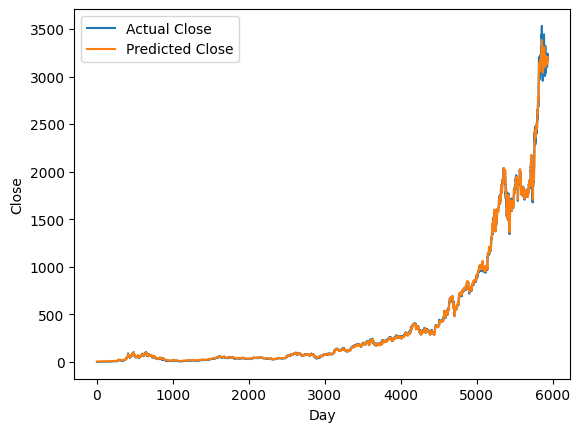

In [32]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [33]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([3191.47171666, 3213.08114331, 3237.01408771, 3246.21500463,
       3246.9752447 , 3230.47495593, 3225.45430337, 3199.15726691,
       3186.0723336 , 3181.98544571, 3162.91430271, 3152.94592016,
       3157.39886603, 3151.28715392, 3141.54832186, 3139.09196495,
       3174.18528697, 3208.78849371, 3230.34311726, 3247.0510575 ,
       3265.51147394, 3254.48415779, 3246.55694036, 3231.1682762 ,
       3252.47434049, 3274.68371094, 3276.19162972, 3283.93087143,
       3293.61378878, 3292.5639705 , 3286.71749201, 3277.50934954,
       3265.545045  , 3260.74416063, 3254.76106348, 3260.47225725,
       3269.37792667, 3258.17341755, 3234.91167209, 3221.18722114,
       3200.99767261, 3159.76006787, 3139.94335824, 3140.24349689,
       3128.71872872, 3098.38115911, 3070.14233677, 3055.8819716 ,
       3030.26335963, 3044.05272945, 3055.53269915, 3082.67723822,
       3096.01451031, 3103.06209919, 3109.64647409, 3123.30889639,
       3103.57044513, 3102.00538884, 3109.72951245, 3122.38969

In [34]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([3283.959996  , 3322.00001254, 3285.85009133, 3256.92995426,
       3186.6299245 , 3218.50998442, 3138.37985822, 3162.15995425,
       3182.69999801, 3114.20991545, 3120.83008466, 3165.88989947,
       3127.46992963, 3104.24998125, 3120.76005231, 3263.37993375,
       3306.98996773, 3292.2299273 , 3293.99996717, 3326.1299203 ,
       3232.58003946, 3237.62014545, 3206.19996463, 3342.87987995,
       3380.00002713, 3312.53008248, 3330.99994773, 3352.14993992,
       3322.93989115, 3305.00004852, 3286.58009521, 3262.12991187,
       3277.70999778, 3268.94995119, 3308.63984098, 3328.23000152,
       3249.89992905, 3180.7399815 , 3194.50000443, 3159.53007274,
       3057.15989525, 3092.92997434, 3146.13988731, 3094.53004681,
       3005.00002289, 2977.57001862, 3000.45992565, 2951.94996153,
       3062.85007932, 3057.63989476, 3113.59007357, 3089.48994082,
       3081.67988862, 3091.86014681, 3135.72996747, 3027.98997614,
       3074.96000668, 3110.87015047, 3137.50000734, 3087.07004

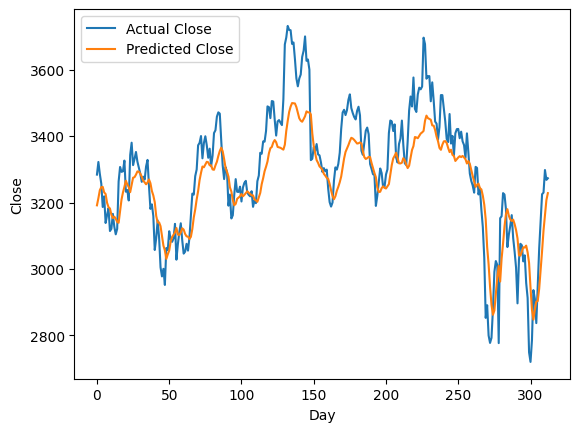

In [35]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()